# Lab 5: Spam Detection

**Deadline**: Thursday, March 12, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Karthik Bhaskar 

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:https://drive.google.com/file/d/1Ws_gOrbRo576aDc6K0uL0M9d27a_qyZi/view?usp=sharing

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
line1=[]

for line in open('/content/drive/My Drive/spamdetection/SMSSpamCollection'):
  line1.append(line)

for line in line1:
  words_in_line = line.split()
  if words_in_line[0] == "spam":
    print("label value for spam message is 'spam'")
    print("Example of Spam Message:")
    print(line)
    break
for line in line1:
  words_in_line = line.split()
  if words_in_line[0] == "ham":
    print("label value for non-spam message is 'ham'")
    print("Example of non-spam Message:")
    print(line)
    break




label value for spam message is 'spam'
Example of Spam Message:
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

label value for non-spam message is 'ham'
Example of non-spam Message:
ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
countSpam=0
countNonSpam=0

for line in line1:
  words_in_line = line.split()
  if words_in_line[0] == "spam":
    countSpam+=1
  if words_in_line[0] == "ham":
    countNonSpam+=1

print("Number of Spam messages: ", countSpam)
print("Number of Non Spam messages: ", countNonSpam)



Number of Spam messages:  747
Number of Non Spam messages:  4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages:
1. Model which is character based has more parameters that can be trained, making it more suitable for complex languages
2. Less memory is needed due to lesser number of characters than words

Disadvantages:
1. Characters have a higher computational cost due to more parameters
2. When the model makes an error, it may output a word which does not exist

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("/content/drive/My Drive/spamdetection/SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)


print(dataset[0].sms)
print(dataset[0].label)
train, valid, test = dataset.split(split_ratio=[0.6,0.2,0.2], random_state=np.random.seed(360))

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
0


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
#The reason why we duplicate the spam messages is because, we have more non-spam
#messages, this creates an imbalance that will result in the model being biased
#towards non-spam messages. Hence by creating duplicates we are introducing
#more spam messages to balance the data and counteract the bias in the dataset.

# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)
print(text_field.vocab.stoi, '\n')

print(text_field.vocab.itos)


#stoi – A dictionary mapping characters to numerical identifiers/indices.
#itos – A list of characters in the training dataset.

defaultdict(<function _default_unk_index at 0x7f530fb73400>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, '2': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, '5': 32, 'S': 33, 'C': 34, 'O': 35, 'I': 36, '4': 37, '7': 38, 'x': 39, 'N': 40, 'A': 41, '6': 42, '3': 43, '!': 44, 'R': 45, ',': 46, '9': 47, 'P': 48, 'U': 49, 'W': 50, 'M': 51, 'L': 52, 'H': 53, 'D': 54, 'G': 55, 'B': 56, 'Y': 57, "'": 58, '/': 59, 'F': 60, '?': 61, '£': 62, '&': 63, '-': 64, ':': 65, 'X': 66, 'z': 67, 'V': 68, 'j': 69, 'K': 70, '*': 71, ')': 72, 'J': 73, '+': 74, ';': 75, '(': 76, 'q': 77, 'Q': 78, '"': 79, '#': 80, '>': 81, '=': 82, '@': 83, 'Z': 84, 'ü': 85, '$': 86, 'Ü': 87, '<': 88, '‘': 89, '_': 90, '\x92': 91, '%': 92, '|': 93, '[': 94, ']': 95, '\x93': 96, '¡': 97, '’': 98, 'ú': 99, '“': 100, '…': 101, '\x94': 102, '

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

`<unk>` represents unknown characters, not present in collection  

`<pad>` represents padding/space token

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
countBatch=0
padTokens = []
maxLengths=[]

i=1
pad=0

for batch in train_iter:
  if(i>10):
    break
  print('Maximum input sequence in batch ' + str(i) + ' is ' + str(batch.sms[0].shape[1]))
  for j in batch.sms[0]:
    for k in j:
      if(k==1):
        pad+= 1
  print('Number of pad tokens in batch ' + str(i) + ' is ' + str(pad))
  pad=0
  i+=1


Maximum input sequence in batch 1 is 138
Number of pad tokens in batch 1 is 25
Maximum input sequence in batch 2 is 125
Number of pad tokens in batch 2 is 35
Maximum input sequence in batch 3 is 40
Number of pad tokens in batch 3 is 24
Maximum input sequence in batch 4 is 81
Number of pad tokens in batch 4 is 19
Maximum input sequence in batch 5 is 159
Number of pad tokens in batch 5 is 0
Maximum input sequence in batch 6 is 54
Number of pad tokens in batch 6 is 24
Maximum input sequence in batch 7 is 149
Number of pad tokens in batch 7 is 0
Maximum input sequence in batch 8 is 155
Number of pad tokens in batch 8 is 0
Maximum input sequence in batch 9 is 143
Number of pad tokens in batch 9 is 28
Maximum input sequence in batch 10 is 129
Number of pad tokens in batch 10 is 80


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
NumberOfChar= len(text_field.vocab.itos)
ident = torch.eye(NumberOfChar)

class RNNNormal(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNNormal, self).__init__()
        self.emb = nn.Embedding.from_pretrained(ident)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).cuda()
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
         # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])

        return out

class RNNSecond(nn.Module): #RNNMax
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNSecond, self).__init__()
        self.emb = nn.Embedding.from_pretrained(ident)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).cuda()
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        out = self.fc(torch.max(out, dim=1)[0])
        return out

class RNNThird(nn.Module):  #RNNMM
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNNThird, self).__init__()
        self.emb = nn.Embedding.from_pretrained(ident)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).cuda()
        # Forward propagate the RNN
        out, _ = self.rnn(x,h0)
        out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
        
        out = self.fc(out)
       
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        t = tweets[0].cuda()
        labels = labels.cuda()
        output = model(t)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [ ]:
import matplotlib.pyplot as plt

def train_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-5):
    torch.manual_seed(360)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    it = []
    iterator = 0
    for epoch in range(num_epochs):
        for tweets, labels in train_loader:
            t = tweets[0].cuda()
            labels = labels.cuda()
            iterator +=1
            optimizer.zero_grad()
            pred = model(t)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
            it.append(iterator)
            losses.append(float(loss))
  
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
           

    print('Training accuracy:'+str(train_acc[-1]))
    print('Validation accuracy:'+str(valid_acc[-1]))

    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

batchSize = 16
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=batchSize,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
valid_iter = torchtext.data.BucketIterator(valid,
                                           batch_size=batchSize,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

Training accuracy:0.9476851078054488
Validation accuracy:0.9497757847533632


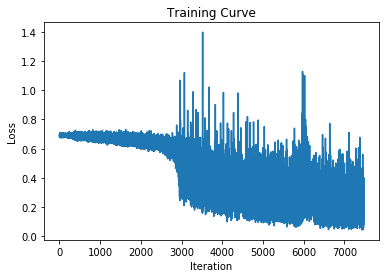

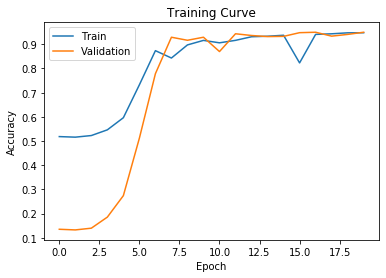

In [ ]:

r = RNNThird(len(ident[0]), len(ident[0]), 2)
r = r.cuda()
train_network(r,train_iter,valid_iter,num_epochs = 20,learning_rate=1e-5) 

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Training accuracy:0.9414421950811444
Validation accuracy:0.9309417040358744


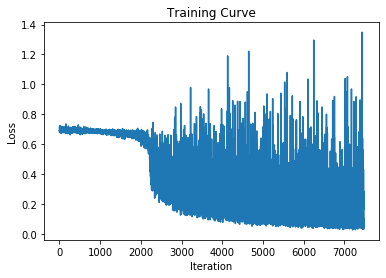

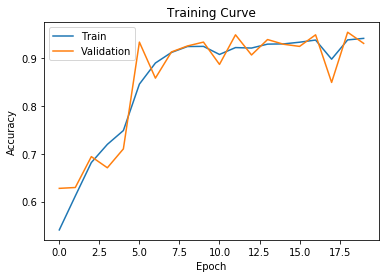

In [ ]:
# 20 epochs and learning rate of 10^(-5), with a normal RNN
r1 = RNNNormal(len(ident[0]), len(ident[0]), 2)
r1 = r1.cuda()
train_network(r1,train_iter,valid_iter,num_epochs = 20,learning_rate=1e-5)

Training accuracy:0.956499916345993
Validation accuracy:0.9434977578475336


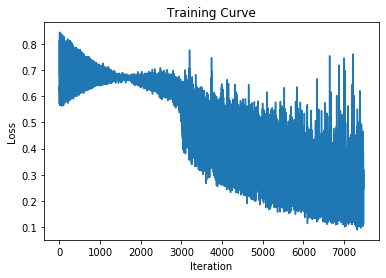

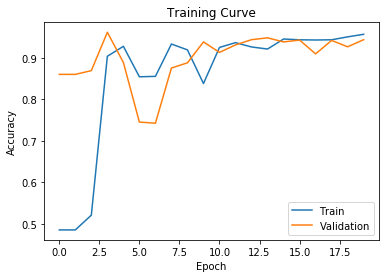

In [ ]:
# change RNN to max pooling layer
r2 = RNNSecond(len(ident[0]), len(ident[0]), 2)
r2= r2.cuda()
train_network(r2,train_iter,valid_iter,num_epochs = 20,learning_rate=1e-5)

Training accuracy:0.9272210138865652
Validation accuracy:0.9650224215246637


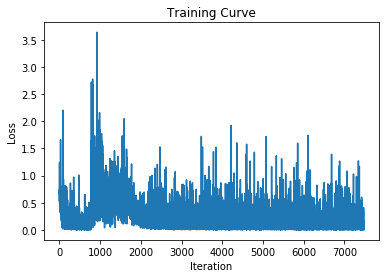

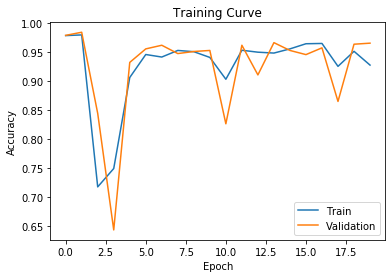

In [ ]:

# change learning rate to 0.005
r3 = RNNSecond(len(ident[0]), len(ident[0]), 2)
r3 = r3.cuda()
train_network(r3,train_iter,valid_iter,num_epochs = 20,learning_rate=0.005)

Training accuracy:0.9580056884724778
Validation accuracy:0.9497757847533632


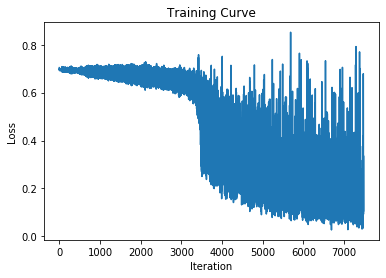

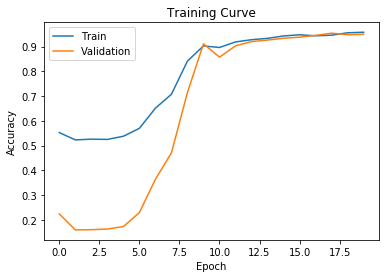

In [ ]:
# change learning rate to 10^(-5) and RNN to max and averaging pooling layer
r4 = RNNThird(len(ident[0]), len(ident[0]), 2)
r4 = r4.cuda()
train_network(r4,train_iter,valid_iter,num_epochs = 20,learning_rate=1e-5)

Based on the hyperparameter tuning process, it is noticeable that best accuracy is achieved when the third (max and averaging pooling layer) RNN is used as recommended. Further, the learning rate can remain 1e-5, which performed well enough. Further, 20 epochs seem to be a reasonable number to well-train the model and avoid overfitting. The best final accuracy for validation was 96.5% and for training was 95.8%. 

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

valid_spam_iter = torchtext.data.BucketIterator(valid_spam,
                                           batch_size=batchSize,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epoc
valid_nospam_iter = torchtext.data.BucketIterator(valid_nospam,
                                           batch_size=batchSize,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

print('False positive rate: ', 1-get_accuracy(r4,valid_nospam_iter))
print('False negative rate: ', 1-get_accuracy(r4,valid_spam_iter))


False positive rate:  0.051094890510948954
False negative rate:  0.07051282051282048


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

If the false positive rate is very high, this means that many messages which are non-spam will be classified as spam. Due to this, an important message could be lost to spam. If the false negative rate is very high, then many spam messages will be classified as not spam, and your inbox would be full of spam messages.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
test_iter = torchtext.data.BucketIterator(test,
                                           batch_size=batchSize,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

print('Test accuracy: ', get_accuracy(r4,test_iter))

Test accuracy:  0.9353680430879713


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    valid.fields)

test_spam_iter = torchtext.data.BucketIterator(test_spam,
                                           batch_size=batchSize,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epoc
test_nospam_iter = torchtext.data.BucketIterator(test_nospam,
                                           batch_size=batchSize,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
                                           
print('False positive rate: ', 1-get_accuracy(r4,test_nospam_iter))
print('False negative rate: ', 1-get_accuracy(r4,test_spam_iter))

False positive rate:  0.06340956340956339
False negative rate:  0.09210526315789469


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
s = torch.zeros(len(msg))
i = 0
for x in msg:
  s[i] = (text_field.vocab.stoi[x])
  i += 1
m = torch.zeros([batchSize,len(msg)])
for x in range(batchSize):
  m[x] = s
m = m.cuda()
m = torch.tensor(m).to(torch.int64)
out = r4(m)
print('Probability of message being spam is: ', 1/(1+np.exp(-float(out[0][1]))))

Probability of message being spam is:  0.2904154628241914


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Spam detection in general in a difficult task to complete, mainly due to the wide amount of data required to train the model to a high level of accuracy. We require a balance of data which is half spam and half not spam for the model to be trained accurately. Though our model receives a satisfactory training error, it still cannot detect all types of spam messages. Further, it is a major issue if our model classifies important emails as spam. So it has to be well-trained.

A baseline model can be a simple algorithm that iterates over an email txt file and detects if the txt file contains any website link or phone number. Usually, these are the main characteristics of a spam message, so this can become a good baseline model.